Note: you may need to restart the kernel to use updated packages.


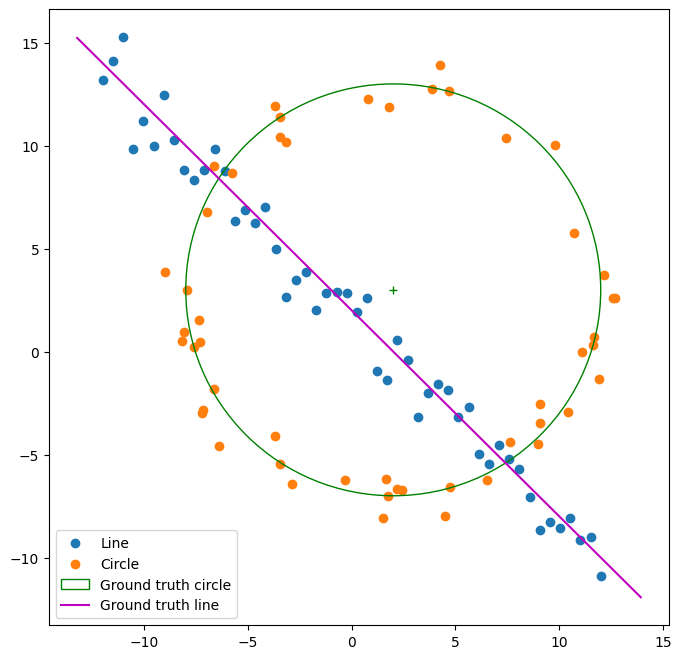

In [ ]:

import numpy as np
from scipy.optimize import minimize
from scipy import linalg
import matplotlib.pyplot as plt
#import tikzplotlib

# np.random.seed(0)
N = 100
half_n = N // 2

r = 10
x0_gt, y0_gt = 2, 3     # Ground truth circle center
s = r / 16


t = np.random.uniform(0, 2 * np.pi, half_n)
n = s * np.random.randn(half_n)

x = x0_gt + (r + n) * np.cos(t)
y = y0_gt + (r + n) * np.sin(t)

X_circ = np.hstack((x.reshape(half_n, 1), y.reshape(half_n, 1)))
s = 1.0
m, b = -1, 2
x = np.linspace(-12, 12, half_n)
y = m * x + b + s * np.random.randn(half_n)

X_line = np.hstack((x.reshape(half_n, 1), y.reshape(half_n, 1)))

# Combine circle and line points
X = np.vstack((X_circ, X_line))

fig, ax = plt.subplots(1, 1, figsize=(8, 8))
ax.scatter(X_line[:, 0], X_line[:, 1], label='Line')
ax.scatter(X_circ[:, 0], X_circ[:, 1], label='Circle')

circle_gt = plt.Circle((x0_gt, y0_gt), r, color='g', fill=False, label='Ground truth circle')
ax.add_patch(circle_gt)
ax.plot(x0_gt, y0_gt, '+', color='g')

x_min, x_max = ax.get_xlim()
x_ = np.array([x_min, x_max])
y_ = m * x_ + b

plt.plot(x_, y_, color='m', label='Ground truth line')
plt.legend()
plt.show()


In [5]:
print(len(X_line))
print(len(X))

50
100


In [ ]:
def get_line_equation(pt_a, pt_b):
    # line through pt_a and pt_b in ax + by + c = 0
    A = pt_a[1] - pt_b[1]
    B = pt_b[0] - pt_a[0]
    C = -(A * pt_a[0] + B * pt_a[1])
    
    # normalize so that sqrt(A^2 + B^2) = 1
    norm_factor = np.sqrt(A**2 + B**2)
    A /= norm_factor
    B /= norm_factor
    C /= norm_factor
    
    return A, B, C


def point_line_distance(line_params, pt):
    A, B, C = line_params
    return np.abs(A * pt[0] + B * pt[1] + C)

In [ ]:
def ransac_line_fit(data_points, num_trials):
    best_inliers = []
    chosen_line = None
    chosen_pair = None
    
    for trial in range(num_trials):
        # random 2 points
        sample_ids = np.random.choice(data_points.shape[0], size=2, replace=False)
        candidate_line = get_line_equation(data_points[sample_ids][0], data_points[sample_ids][1])
        
        # measure inliers
        inlier_ids = []
        for idx, p in enumerate(data_points):
            err = point_line_distance(candidate_line, p)
            if err < 1.4:   # threshold based on noise level
                inlier_ids.append(idx)
        
        # update best model
        if len(inlier_ids) > len(best_inliers):
            best_inliers = inlier_ids
            chosen_line = candidate_line
            chosen_pair = sample_ids
            
    return chosen_line, best_inliers, chosen_pair
# Run RANSAC
line_model, inliers_line, line_sample = ransac_line_fit(X, 17)
print(f"Estimated line params: A={line_model[0]:.3f}, B={line_model[1]:.3f}, C={line_model[2]:.3f}")


Estimated line params: A=-0.701, B=-0.713, C=1.328


In [ ]:

def fit_circle_three_pts(p_a, p_b, p_c):
    A = np.array([
        [p_a[0], p_a[1], 1],
        [p_b[0], p_b[1], 1],
        [p_c[0], p_c[1], 1]
    ])
    B = np.array([
        [-(p_a[0]**2 + p_a[1]**2)],
        [-(p_b[0]**2 + p_b[1]**2)],
        [-(p_c[0]**2 + p_c[1]**2)]
    ])

    detA = np.linalg.det(A)
    if np.isclose(detA, 0):
        return None  # points are collinear, no circle

    D = np.linalg.det(np.hstack((B, A[:, 1:])))
    E = np.linalg.det(np.hstack((A[:, 0:1], B, A[:, 2:])))
    F = np.linalg.det(np.hstack((A[:, :2], B)))

    cx = -D / (2 * detA)
    cy = -E / (2 * detA)
    R = np.sqrt((D**2 + E**2 - 4 * detA * F) / (4 * detA**2))

    return cx, cy, R


def fit_circle_cv(p_a, p_b, p_c):
    pts = np.array([p_a, p_b, p_c], dtype=np.float32)
    (cx, cy), R = cv.minEnclosingCircle(pts)
    return cx, cy, R


def circle_point_error(circle_params, point):
    cx, cy, R = circle_params
    dist = np.sqrt((point[0] - cx)**2 + (point[1] - cy)**2)
    return np.abs(dist - R)


In [9]:
def ransac_circle_fit(data_points, num_trials):
    max_inliers = []
    best_circle = None
    best_sample = None

    for t in range(num_trials):
        sample_ids = np.random.choice(data_points.shape[0], size=3, replace=False)
        circ = fit_circle_three_pts(data_points[sample_ids][0],
                                    data_points[sample_ids][1],
                                    data_points[sample_ids][2])
        if circ is None:
            continue

        inlier_ids = []
        for idx, p in enumerate(data_points):
            if circle_point_error(circ, p) < 0.6:  # radial threshold
                inlier_ids.append(idx)

        if len(inlier_ids) > len(max_inliers):
            max_inliers = inlier_ids
            best_circle = circ
            best_sample = sample_ids

    return best_circle, max_inliers, best_sample

# Remove line inliers before fitting circle
remaining_pts = np.delete(X, inliers_line, axis=0)

circle_model, inliers_circle_local, circle_sample = ransac_circle_fit(remaining_pts, 40)
print(f"Estimated circle: Center=({circle_model[0]:.3f},{circle_model[1]:.3f}) Radius={circle_model[2]:.3f}")

# Adjust inlier indices to global X
global_inliers_circle = [i for i in range(X.shape[0]) if i not in inliers_line]
inliers_circle = [global_inliers_circle[i] for i in inliers_circle_local]


Estimated circle: Center=(2.122,2.999) Radius=10.067


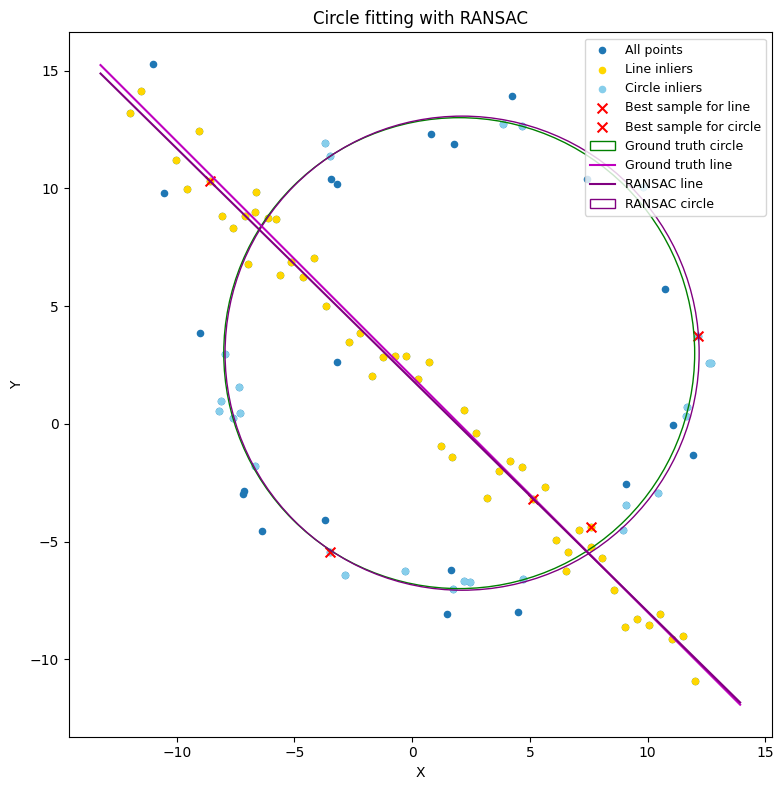

In [ ]:

fig, ax = plt.subplots(figsize=(8, 8))
ax.scatter(X[:, 0], X[:, 1], color='tab:blue', label='All points', s=20)
ax.scatter(X[inliers_line, 0], X[inliers_line, 1], color='gold', label='Line inliers', s=20)
ax.scatter(X[inliers_circle, 0], X[inliers_circle, 1], color='skyblue', label='Circle inliers', s=20)
ax.scatter(X[line_sample, 0], X[line_sample, 1], marker='x', color='red', s=50, label='Best sample for line')
ax.scatter(X[circle_sample, 0], X[circle_sample, 1], marker='x', color='red', s=50, label='Best sample for circle')

# Ground truth shapes
gt_circle = plt.Circle((x0_gt, y0_gt), r, color='g', fill=False, label='Ground truth circle')
ax.add_patch(gt_circle)
ax.plot(x_, m * x_ + b, color='m', label='Ground truth line')

# RANSAC estimated line and circle
ax.plot(x_, -(line_model[0] * x_ + line_model[2]) / line_model[1], color='purple', label='RANSAC line')
est_circle = plt.Circle((cx, cy), R, color='purple', fill=False, label='RANSAC circle')
ax.add_patch(est_circle)

ax.set_aspect('equal', adjustable='box')
ax.legend(loc='upper right', fontsize=9)
ax.set_title('Circle fitting with RANSAC', fontsize=12)
plt.xlabel('X')
plt.ylabel('Y')
plt.tight_layout()
plt.show()
